In [1]:
# assign folder paths for all the dicom images (these are the ones provided by Vahid and Dr. Motamed)
import SimpleITK as sitk
import numpy as np
import os
from AortaGeomReconDisplayModuleLib.AortaSegmenter import AortaSegmenter
%matplotlib inline
from matplotlib.pyplot import figure

In [2]:
def get_cropped_volume_image(testCase):
    """Read the cropped volume from /project-repo/test/sample

    Returns:
        SITK: The cropped volume sitk image
    """
    sample = 43681283
    if testCase == 1:
        sample = 22429388
    elif testCase == 2:
        sample = 62023082
    elif testCase == 3:
        sample = 75962810
    elif testCase == 4:
        sample = "07323651"
    elif testCase == 5:
        sample = "05937785"
    abspath = os.path.abspath("./backup/{}_crop.vtk".format(sample))
    return sitk.ReadImage(abspath)

In [15]:
def myshow(img, title=None, margin=0.05, dpi=80 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    elif nda.ndim == 4:
        c = nda.shape[-1]
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
    ysize = nda.shape[0]
    xsize = nda.shape[1]
    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    # figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    fig = figure(figsize=(5, 10), dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    t = ax.imshow(nda,extent=extent,interpolation=None)
    if nda.ndim == 2:
        t.set_cmap("gray")
    if(title):
        plt.title(title)

In [16]:
des_starting_slice = 829
des_aorta_centre = [23, 28]

In [17]:
asc_starting_slice = 749
asc_aorta_centre = [87, 130]

In [18]:
crop = get_cropped_volume_image(0)

In [19]:
# Takes the maximum slice number and start from there
starting_slice = max(des_starting_slice, asc_starting_slice)

In [34]:
cur_img_slice = crop[:, :, 749]

In [35]:
sitk.GetArrayFromImage(cur_img_slice).shape

(187, 123)

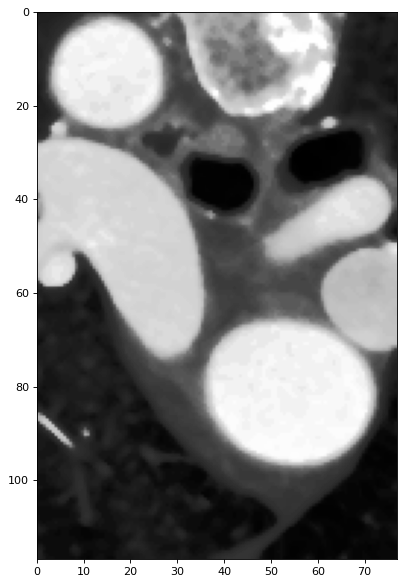

In [36]:
myshow(cur_img_slice)

In [181]:
def prepare_label_map(cur_img_slice, prev_centre1, prev_centre2):
    """Create a label map image that has a circle-like shape.
    The pixels within the circle are labeled as white pixels (value of 1), the other are labeled as black pixels (value of 0).

    Returns:
        SITK::IMAGE: A label map image that has a circle like shape.
    """ # noqa
    label_map = sitk.Image(cur_img_slice.GetSize(), sitk.sitkUInt8)
    label_map.CopyInformation(cur_img_slice)
    label_map[prev_centre1] = 1
    if prev_centre2:
        label_map[prev_centre2] = 1
    # add original seed and additional seeds three pixels apart
    label_map = sitk.BinaryDilate(label_map, [5] * 2)
    return label_map

In [63]:
label_map = prepare_label_map(cur_img_slice, des_aorta_centre, asc_aorta_centre)

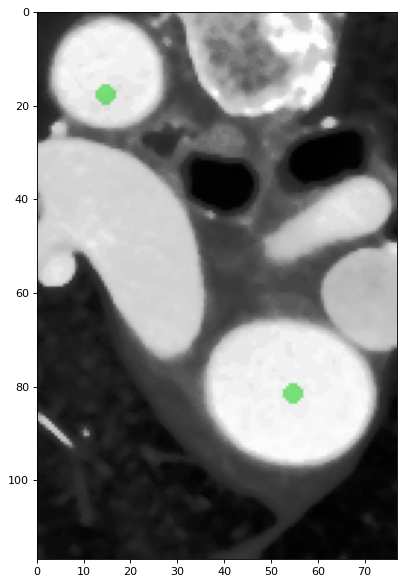

In [64]:
myshow(sitk.LabelOverlay(cur_img_slice, label_map))

In [65]:
# calculate the Euclidean distance transform
dis_map = sitk.SignedMaurerDistanceMap(label_map, insideIsPositive=True, useImageSpacing=True)

In [66]:
stats_filter = sitk.LabelStatisticsImageFilter()

In [67]:
stats_filter.Execute(cur_img_slice, label_map)

In [125]:
intensity_mean = stats_filter.GetMean(1)
std = stats_filter.GetSigma(1)
lower_threshold = (intensity_mean - 10*std)
upper_threshold = (intensity_mean + 10*std)

In [126]:
lower_threshold, upper_threshold

(176.4645747363641, 299.6975874257981)

In [172]:
segment_filter = sitk.ThresholdSegmentationLevelSetImageFilter()
segment_filter.SetMaximumRMSError(0.02)
segment_filter.SetNumberOfIterations(1000)
segment_filter.SetCurvatureScaling(0.05)
segment_filter.SetPropagationScaling(2)
segment_filter.ReverseExpansionDirectionOn()

In [128]:
segment_filter.SetLowerThreshold(lower_threshold)
segment_filter.SetUpperThreshold(upper_threshold)

In [129]:
segmented_slice = segment_filter.Execute(dis_map, sitk.Cast(cur_img_slice, sitk.sitkFloat32))

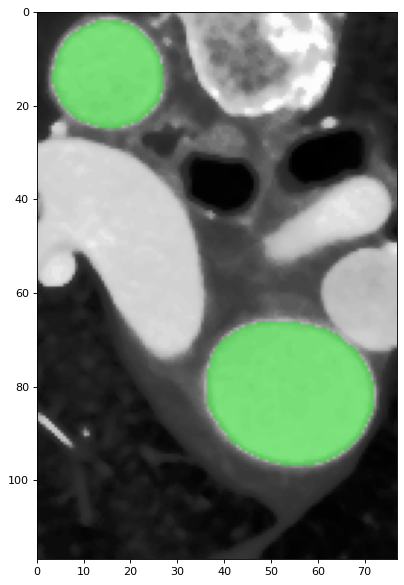

In [130]:
myshow(sitk.LabelOverlay(cur_img_slice, segmented_slice>0))

In [101]:
# use idea of clustering
nda = sitk.GetArrayFromImage(segmented_slice>0)

In [102]:
list_y, list_x = np.where(nda==1)

In [104]:
len(list_y),len(list_x)

(2975, 2975)

In [105]:
max(list_y), min(list_y)

(153, 4)

In [106]:
max(list_x), min(list_x)

(113, 7)

In [132]:
def get_dist(point1, point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

In [138]:
clusters = {}
des_dist = [get_dist((list_x[i], list_y[i]), des_aorta_centre) for i in range(len(list_y))]
asc_dist = [get_dist((list_x[i], list_y[i]), asc_aorta_centre) for i in range(len(list_y))]
clusters["des"] = []
clusters["asc"] = []

In [139]:
for i in range(len(des_dist)):
    if des_dist[i] < asc_dist[i]:
        clusters["des"].append((list_x[i], list_y[i]))
    else:
        clusters["asc"].append((list_x[i], list_y[i]))

In [140]:
clusters

{'des': [(21, 4),
  (22, 4),
  (23, 4),
  (24, 4),
  (25, 4),
  (19, 5),
  (20, 5),
  (21, 5),
  (22, 5),
  (23, 5),
  (24, 5),
  (25, 5),
  (26, 5),
  (27, 5),
  (28, 5),
  (29, 5),
  (30, 5),
  (16, 6),
  (17, 6),
  (18, 6),
  (19, 6),
  (20, 6),
  (21, 6),
  (22, 6),
  (23, 6),
  (24, 6),
  (25, 6),
  (26, 6),
  (27, 6),
  (28, 6),
  (29, 6),
  (30, 6),
  (31, 6),
  (32, 6),
  (15, 7),
  (16, 7),
  (17, 7),
  (18, 7),
  (19, 7),
  (20, 7),
  (21, 7),
  (22, 7),
  (23, 7),
  (24, 7),
  (25, 7),
  (26, 7),
  (27, 7),
  (28, 7),
  (29, 7),
  (30, 7),
  (31, 7),
  (32, 7),
  (33, 7),
  (34, 7),
  (13, 8),
  (14, 8),
  (15, 8),
  (16, 8),
  (17, 8),
  (18, 8),
  (19, 8),
  (20, 8),
  (21, 8),
  (22, 8),
  (23, 8),
  (24, 8),
  (25, 8),
  (26, 8),
  (27, 8),
  (28, 8),
  (29, 8),
  (30, 8),
  (31, 8),
  (32, 8),
  (33, 8),
  (34, 8),
  (35, 8),
  (12, 9),
  (13, 9),
  (14, 9),
  (15, 9),
  (16, 9),
  (17, 9),
  (18, 9),
  (19, 9),
  (20, 9),
  (21, 9),
  (22, 9),
  (23, 9),
  (24, 9),
  (

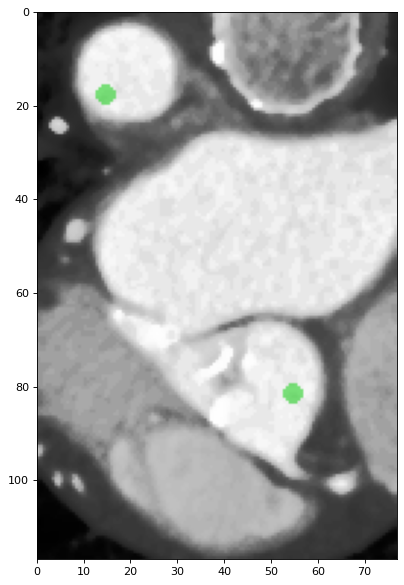

In [155]:
# keep track of the maximum moving distance
cur_img_slice = crop[:, :, 500]
label_map = prepare_label_map(cur_img_slice, des_aorta_centre, asc_aorta_centre)
myshow(sitk.LabelOverlay(cur_img_slice, label_map))

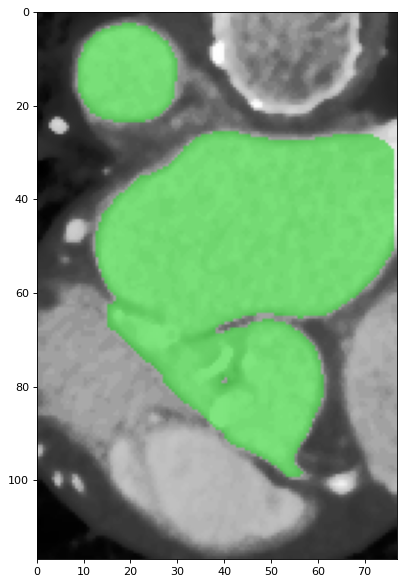

In [156]:
# calculate the Euclidean distance transform
dis_map = sitk.SignedMaurerDistanceMap(label_map, insideIsPositive=True, useImageSpacing=True)
stats_filter.Execute(cur_img_slice, label_map)
intensity_mean = stats_filter.GetMean(1)
std = stats_filter.GetSigma(1)
lower_threshold = (intensity_mean - 13*std)
upper_threshold = (intensity_mean + 13*std)
segment_filter.SetLowerThreshold(lower_threshold)
segment_filter.SetUpperThreshold(upper_threshold)
segmented_slice = segment_filter.Execute(dis_map, sitk.Cast(cur_img_slice, sitk.sitkFloat32))
myshow(sitk.LabelOverlay(cur_img_slice, segmented_slice>0))

In [157]:
nda = sitk.GetArrayFromImage(segmented_slice>0)
clusters = {}
des_dist = [get_dist((list_x[i], list_y[i]), des_aorta_centre) for i in range(len(list_y))]
asc_dist = [get_dist((list_x[i], list_y[i]), asc_aorta_centre) for i in range(len(list_y))]
clusters["des"] = []
clusters["asc"] = []
for i in range(len(des_dist)):
    if des_dist[i] < asc_dist[i]:
        clusters["des"].append((list_x[i], list_y[i]))
    else:
        clusters["asc"].append((list_x[i], list_y[i]))

In [144]:
clusters

{'des': [(21, 4),
  (22, 4),
  (23, 4),
  (24, 4),
  (25, 4),
  (19, 5),
  (20, 5),
  (21, 5),
  (22, 5),
  (23, 5),
  (24, 5),
  (25, 5),
  (26, 5),
  (27, 5),
  (28, 5),
  (29, 5),
  (30, 5),
  (16, 6),
  (17, 6),
  (18, 6),
  (19, 6),
  (20, 6),
  (21, 6),
  (22, 6),
  (23, 6),
  (24, 6),
  (25, 6),
  (26, 6),
  (27, 6),
  (28, 6),
  (29, 6),
  (30, 6),
  (31, 6),
  (32, 6),
  (15, 7),
  (16, 7),
  (17, 7),
  (18, 7),
  (19, 7),
  (20, 7),
  (21, 7),
  (22, 7),
  (23, 7),
  (24, 7),
  (25, 7),
  (26, 7),
  (27, 7),
  (28, 7),
  (29, 7),
  (30, 7),
  (31, 7),
  (32, 7),
  (33, 7),
  (34, 7),
  (13, 8),
  (14, 8),
  (15, 8),
  (16, 8),
  (17, 8),
  (18, 8),
  (19, 8),
  (20, 8),
  (21, 8),
  (22, 8),
  (23, 8),
  (24, 8),
  (25, 8),
  (26, 8),
  (27, 8),
  (28, 8),
  (29, 8),
  (30, 8),
  (31, 8),
  (32, 8),
  (33, 8),
  (34, 8),
  (35, 8),
  (12, 9),
  (13, 9),
  (14, 9),
  (15, 9),
  (16, 9),
  (17, 9),
  (18, 9),
  (19, 9),
  (20, 9),
  (21, 9),
  (22, 9),
  (23, 9),
  (24, 9),
  (

In [145]:
len(clusters["des"])

947

In [146]:
len(clusters["asc"])

2028

In [185]:
def segment(slice_i):
    # keep track of the maximum moving distance
    cur_img_slice = crop[:, :, slice_i]
    label_map = prepare_label_map(cur_img_slice, des_aorta_centre, asc_aorta_centre)
    myshow(sitk.LabelOverlay(cur_img_slice, label_map))
    
    # calculate the Euclidean distance transform
    dis_map = sitk.SignedMaurerDistanceMap(label_map, insideIsPositive=True, useImageSpacing=True)
    stats_filter.Execute(cur_img_slice, label_map)
    intensity_mean = stats_filter.GetMean(1)
    std = stats_filter.GetSigma(1)
    lower_threshold = (intensity_mean - 14*std)
    upper_threshold = (intensity_mean + 14*std)
    segment_filter.SetLowerThreshold(lower_threshold)
    segment_filter.SetUpperThreshold(upper_threshold)
    segmented_slice = segment_filter.Execute(dis_map, sitk.Cast(cur_img_slice, sitk.sitkFloat32))
    myshow(sitk.LabelOverlay(cur_img_slice, segmented_slice>0))
    return segmented_slice

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x00000259AA53DF60> >

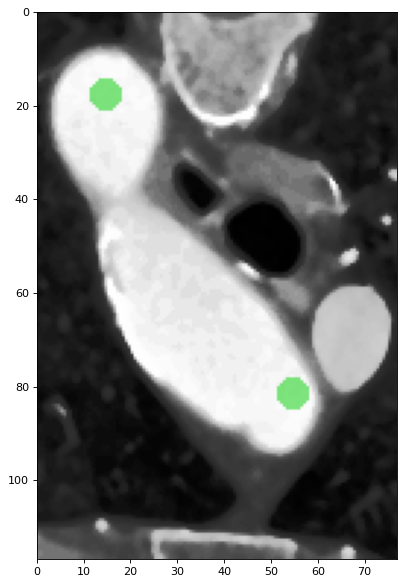

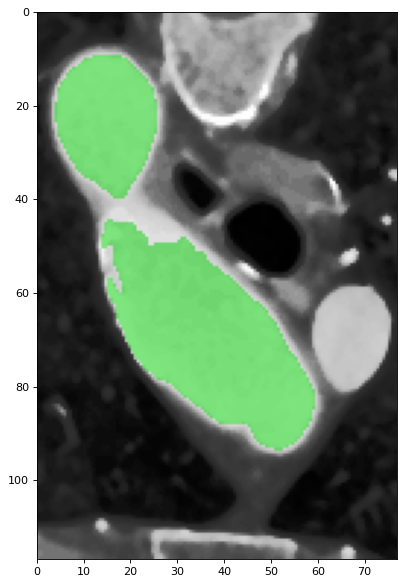

In [183]:
segment(863)

In [189]:
def prepare_label_map(cur_img_slice, prev_centre1, prev_centre2):
    """Create a label map image that has a circle-like shape.
    The pixels within the circle are labeled as white pixels (value of 1), the other are labeled as black pixels (value of 0).

    Returns:
        SITK::IMAGE: A label map image that has a circle like shape.
    """ # noqa
    label_map = sitk.Image(cur_img_slice.GetSize(), sitk.sitkUInt8)
    label_map.CopyInformation(cur_img_slice)
    label_map[prev_centre1] = 1
    if prev_centre2:
        label_map[prev_centre2] = 1
    # add original seed and additional seeds three pixels apart
    label_map = sitk.BinaryDilate(label_map, [8] * 2)
    return label_map

def segment(slice_i):
    # keep track of the maximum moving distance
    cur_img_slice = crop[:, :, slice_i]
    label_map = prepare_label_map(cur_img_slice, des_aorta_centre, asc_aorta_centre)
    myshow(sitk.LabelOverlay(cur_img_slice, label_map))
    
    # calculate the Euclidean distance transform
    dis_map = sitk.SignedMaurerDistanceMap(label_map, insideIsPositive=True, useImageSpacing=True)
    stats_filter.Execute(cur_img_slice, label_map)
    intensity_mean = stats_filter.GetMean(1)
    std = stats_filter.GetSigma(1)
    lower_threshold = (intensity_mean - 10*std)
    upper_threshold = (intensity_mean + 10*std)
    segment_filter.SetLowerThreshold(lower_threshold)
    segment_filter.SetUpperThreshold(upper_threshold)
    segmented_slice = segment_filter.Execute(dis_map, sitk.Cast(cur_img_slice, sitk.sitkFloat32))
    myshow(sitk.LabelOverlay(cur_img_slice, segmented_slice>0))
    return segmented_slice

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x00000259A87F6060> >

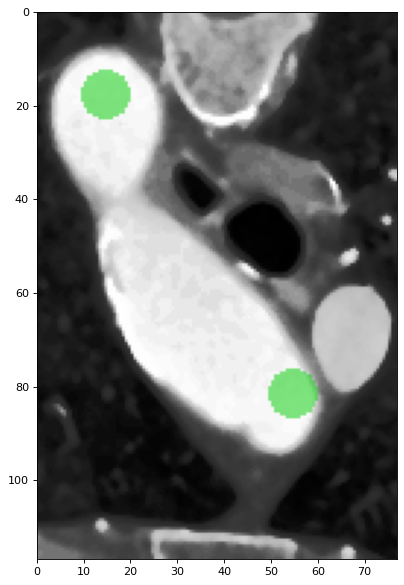

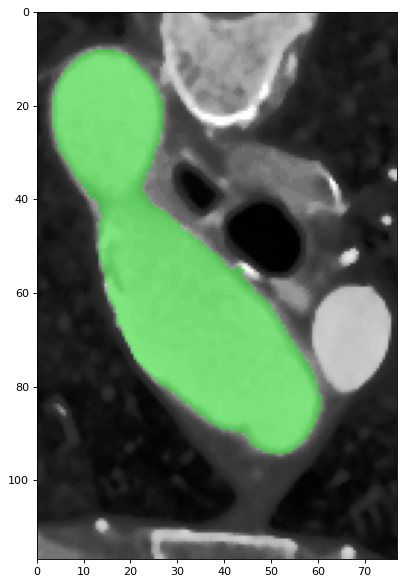

In [190]:
segment(863)